In [2]:
import time
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
offset1 = 0.25
offset2 = 1

def grav_wave(t):
    
    A = np.random.rand(1)
    B = np.random.rand(1)
    C = np.random.rand(1)
    D = 100 + np.random.rand(1)
    E = np.random.rand(1)

    y1 = (A * np.exp(-(np.square((t-0.00)-B))/(np.square(C))) * np.sin(D*t + E))
    y2 = (A * np.exp(-(np.square((t-offset1)-B))/(np.square(C))) * np.sin(D*t + E))
    y3 = (A * np.exp(-(np.square((t-offset2)-B))/(np.square(C))) * np.sin(D*t + E))
    
    # noise = np.random.uniform(-0.5, 0.5, size=y1.shape)
    noise = 0.5 * np.random.normal(0,1,8192)
    
    n1 = y1 + noise
    n2 = y2 + noise
    n3 = y3 + noise
    
    return (n1, n2, n3, y1, y2, y3)


In [4]:
t = np.linspace(-2, 3, 8192)

# Generate Training Data

x_train_1 = []
x_train_2 = []
x_train_3 = []
y_train = []
y_train_2 = []
y_train_3 = []

for i in range(4500):
    wave = grav_wave(t)
    x_train_1.append(wave[0])
    x_train_2.append(wave[1])
    x_train_3.append(wave[2])
    y_train.append(wave[3])
    
    # for displaying purposes
    if i == 0:
        y_train_2.append(wave[4])
        y_train_3.append(wave[5])


Clean wave:


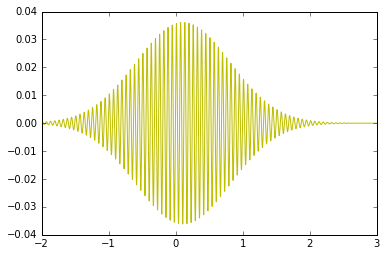

1st Detection:


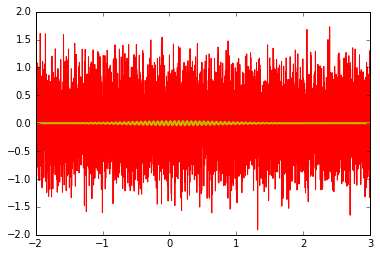

2nd Detection:


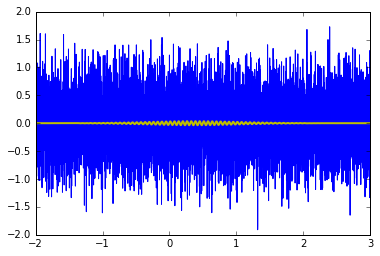

3rd Detection:


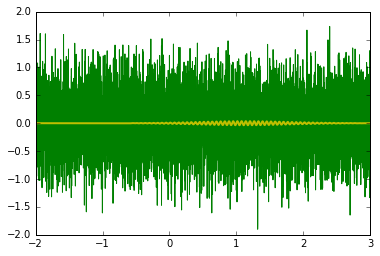

In [5]:
# Display an Example of Training Data

print("Clean wave:")
plt.cla()
plt.plot(t, y_train[0], "y-")
plt.show()

print("1st Detection:")
plt.cla()
plt.plot(t, x_train_1[0], "r-")
plt.plot(t, y_train[0], "y-",linewidth=2.0)
plt.show()

print("2nd Detection:")
plt.cla()
plt.plot(t, x_train_2[0], "b-")
plt.plot(t, y_train_2[0], "y-",linewidth=2.0)
plt.show()

print("3rd Detection:")
plt.cla()
plt.plot(t, x_train_3[0], "g-")
plt.plot(t, y_train_3[0], "y-",linewidth=2.0)
plt.show()


In [6]:
# Generate Testing Data

x_test_1 = []
x_test_2 = []
x_test_3 = []
y_test = []

for i in range(500):
    wave = grav_wave(t)
    x_test_1.append(wave[0])
    x_test_2.append(wave[1])
    x_test_3.append(wave[2])
    y_test.append(wave[3])


In [7]:
# Reshape x_train to have a shape of (4500, 8192, 3)
x_train_1 = np.squeeze(x_train_1)
x_train_2 = np.squeeze(x_train_2)
x_train_3 = np.squeeze(x_train_3)

x_train_1 = np.array(x_train_1)
x_train_2 = np.array(x_train_2)
x_train_3 = np.array(x_train_3)

x_train_1 = np.expand_dims(x_train_1, axis=-1)
x_train_2 = np.expand_dims(x_train_2, axis=-1)
x_train_3 = np.expand_dims(x_train_3, axis=-1)

x_train = np.concatenate((x_train_1, x_train_2, x_train_3), axis=-1)

# Reshape x_test to have a shape of (500, 8192, 3)
x_test_1 = np.squeeze(x_test_1)
x_test_2 = np.squeeze(x_test_2)
x_test_3 = np.squeeze(x_test_3)

x_test_1 = np.array(x_test_1)
x_test_2 = np.array(x_test_2)
x_test_3 = np.array(x_test_3)

x_test_1 = np.expand_dims(x_test_1, axis=-1)
x_test_2 = np.expand_dims(x_test_2, axis=-1)
x_test_3 = np.expand_dims(x_test_3, axis=-1)

x_test = np.concatenate((x_test_1, x_test_2, x_test_3), axis=-1)

# Convert y_train and y_test to NumPy Arrays (from Python Lists)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
def build_model(layers):
    # here layers is a list with 4 elements
    
    model = Sequential()
    
    model.add(LSTM(
        input_dim = layers[0],
        output_dim = layers[1],
        return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[3],
        return_sequences = False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim = layers[4]))
    model.add(Activation("linear"))
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    # try changing whether there is dropout, activation function, loss function, number of layers, in/out of layers
    
    return model

In [9]:
epochs = 10
global_start_time = time.time()

model = build_model([3, 64, 128, 64, 8192])

model.fit(x_train,
          y_train,
          batch_size=64,
          nb_epoch=epochs,
          validation_split=0.05)

predicted = model.predict(x_test)

print('Training duration (min) : ', (time.time() - global_start_time)/60)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=64, return_sequences=True, input_shape=(None, 3))`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=8192)`
/home/arjung2/.local/lib/python2.7/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4275 samples, validate on 225 samples
Epoch 1/10
4275/4275 [==============================] - 2963s 693ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 2/10
4275/4275 [==============================] - 2968s 694ms/step - loss: 0.0122 - val_loss: 0.0127
Epoch 3/10
4275/4275 [==============================] - 2972s 695ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 4/10
4275/4275 [==============================] - 2968s 694ms/step - loss: 0.0107 - val_loss: 0.0113
Epoch 5/10
4275/4275 [==============================] - 2972s 695ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 6/10
4275/4275 [==============================] - 2969s 694ms/step - loss: 0.0110 - val_loss: 0.0114
Epoch 7/10
4275/4275 [==============================] - 2969s 694ms/step - loss: 0.0107 - val_loss: 0.0181
Epoch 8/10
4275/4275 [==============================] - 2970s 695ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 9/10
4275/4275 [==============================] - 2969s 694ms/step - loss: 0.0108 - val_los

In [10]:
t_two = np.linspace(-2, 3, 8192)
avg_mse = 0
for i in range(500):
    avg_mse += np.square(np.sum(y_test[i] - predicted[i]))
    
print("Average MSE: ", avg_mse / 500)

('Average MSE: ', 2.1354587951890509)


A Sample of the Results:
('MSE: ', 0.0057918919788620387)


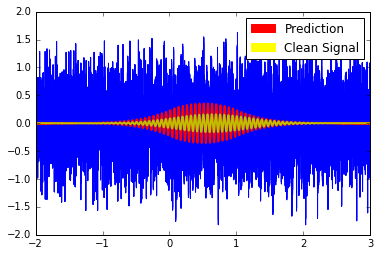

('MSE: ', 0.0055695686941046344)


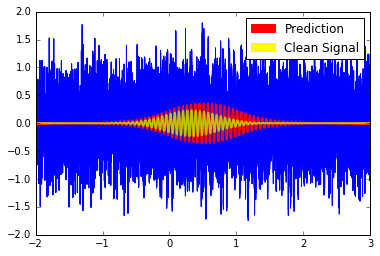

('MSE: ', 0.0054787052344051242)


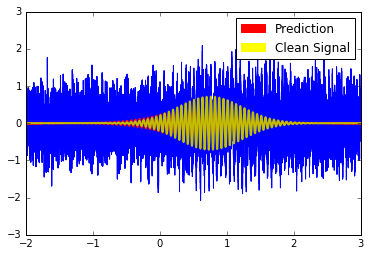

('MSE: ', 0.014568673781481864)


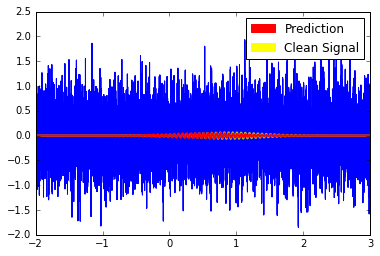

('MSE: ', 0.0054831388133430182)


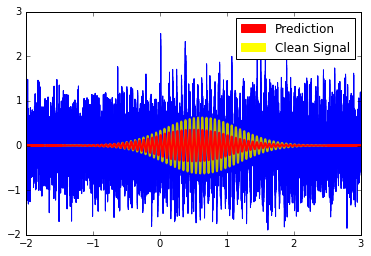

In [15]:
print("A Sample of the Results:")

n = 3
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 4
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 7
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 6
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()

n = 13
print("MSE: ", np.square(np.sum(y_test[n] - predicted[n])))
plt.plot(t_two, x_test[n], "b-", label='Noisy Signal')
plt.plot(t_two, y_test[n], "y-", label='True Data', linewidth=2.0)
plt.plot(t_two, predicted[n], "r-", label='Prediction', linewidth=2.0)
red_patch = mpatches.Patch(color='red', label='Prediction')
yellow_patch = mpatches.Patch(color='yellow', label='Clean Signal')
plt.legend(handles=[red_patch, yellow_patch])
plt.show()